<a href="https://colab.research.google.com/github/mgnarag/machine-learning/blob/main/Unet_32_whole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!ls drive/My\ Drive
file_path = "/content/drive/My Drive/CS284/Project/"

In [4]:
import time
import pandas as pd


import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


from PIL import Image, ImageOps
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from scipy.ndimage import zoom

import cv2

epoch = 100
model_number = 32
size = 32


# Generate augmented images with specific rotations
#zoom_factor = [x/5 for x in range(6, 8)]
zoom_factor = [2.0]


def zoom_and_resize(img, zoom_factor):
    height, width = img.shape[:2]

    # Calculate the region to crop around the center
    crop_top = int((height - height / zoom_factor) / 2)
    crop_bottom = int(height - crop_top)
    crop_left = int((width - width / zoom_factor) / 2)
    crop_right = int(width - crop_left)
    # Crop the image
    cropped_image = img[crop_top:crop_bottom, crop_left:crop_right]
    # Resize the zoomed image back to the original dimensions
    resized_image = cv2.resize(cropped_image, (width, height))

    return resized_image

def crop(im):
    width, height = im.size
    data = []

    for j in np.arange(0,int(height/size)+1,1):
        for i in np.arange(0,int(width/size)+1,1):
            im1 = im.crop((0 + (size*i), 0 + (size*j), size + (size*i), size + (size*j)))
            im1 = np.array(im1)
            im1 = im1.astype(np.float32)
            #im1 = im1/255
            data.append(im1/255)
            #flip_im1 = np.fliplr(im1)

            #rotated_90 = np.rot90(im1)
            #data.append(rotated_90/255)
            #rotated_90 = np.rot90(rotated_90) #180
            #data.append(rotated_90/255)
            #rotated_90 = np.rot90(rotated_90) #270
            #data.append(rotated_90/255)
            #flip
            #rotated_90 = np.rot90(flip_im1)
            #data.append(rotated_90/255)
            #rotated_90 = np.rot90(rotated_90) #180
            #data.append(rotated_90/255)
            #rotated_90 = np.rot90(rotated_90) #270
            #data.append(rotated_90/255)


            # Define the zoom factor (e.g., 1.2 for 20% zoom in)
            for z in zoom_factor:
                zoomed_img = zoom_and_resize(im1, z)
                data.append(zoomed_img/255)



    return data

data = []

input = np.array(crop(Image.open(file_path + "WB_ViganII_NAP.tif").convert('RGB')))
print("Done reading the input of size = ", input.shape)

output = np.array(crop(Image.open(file_path + "CLEAN_ViganII_NAP.png").convert('RGB')))
print("Done reading the output of size = ", input.shape)

train_input = []
test_input = []
for i in range(0,len(input)):
    if i % 4 == 0:
        test_input.append(input[i])
    else:
        train_input.append(input[i])

train_input = np.array(train_input)
test_input = np.array(test_input)

print("Done reading the train input of size = ", train_input.shape)
print("Done reading the test input of size = ", test_input.shape)
input = []

train_output = []
test_output = []
for i in range(0,len(output)):
    if i % 4 == 0:
        test_output.append(output[i])
    else:
        train_output.append(output[i])

train_output = np.array(train_output)
test_output = np.array(test_output)

print("Done reading the train output of size = ", train_input.shape)
print("Done reading the test output of size = ", test_input.shape)

output = []


Done reading the input of size =  (71162, 32, 32, 3)
Done reading the output of size =  (71162, 32, 32, 3)
Done reading the train input of size =  (53371, 32, 32, 3)
Done reading the test input of size =  (17791, 32, 32, 3)
Done reading the train output of size =  (53371, 32, 32, 3)
Done reading the test output of size =  (17791, 32, 32, 3)


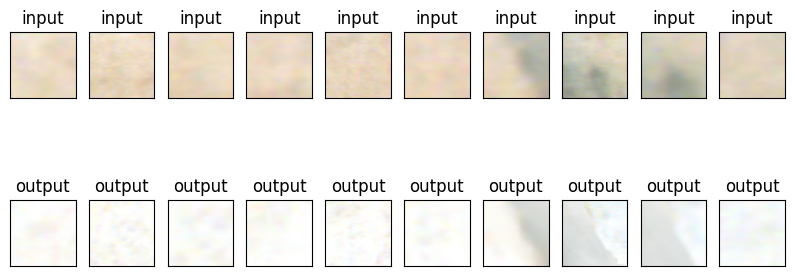

In [9]:

n = 10
plt.figure(figsize=(10, 4))
for i in range(0,10):

    ax = plt.subplot(2, n, i + 1)


    plt.title("input")
    plt.imshow((train_input[i+27000]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    bx = plt.subplot(2, n, i + n + 1)
    plt.title("output")
    plt.imshow((train_output[i+27000]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()



In [11]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization
from tensorflow.keras import layers, losses
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate


def unet_model(input_shape=(32, 32, 3)):
    inputs = Input(input_shape)

    # Contracting Path
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    #conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    #conv1 = BatchNormalization()(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same', strides = 2)(conv1)
    #conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    #conv2 = BatchNormalization()(conv2)

    conv7 = concatenate([Conv2DTranspose(64, kernel_size=3, strides=2, activation='relu', padding='same')(conv2), conv1], axis = -1)
    #conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(conv7)
    #conv7 = BatchNormalization()(conv7)

    # Output Layer
    output = Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same')(conv7)

    model = Model(inputs=inputs, outputs=output)
    return model

# Usage example:
unet = unet_model()
unet.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_9 (Conv2D)           (None, 32, 32, 64)           1792      ['input_2[0][0]']             
                                                                                                  
 conv2d_10 (Conv2D)          (None, 32, 32, 64)           36928     ['conv2d_9[0][0]']            
                                                                                                  
 conv2d_11 (Conv2D)          (None, 16, 16, 128)          73856     ['conv2d_10[0][0]']           
                                                                                            

In [12]:
from keras.optimizers import Adam
opt = Adam(learning_rate=0.0001)
unet.compile(optimizer=opt, loss=losses.MeanSquaredError())
start = time.time()
model = unet.fit(train_input, train_output,
                epochs=epoch,
                shuffle=True,
                validation_data=(test_input, test_output),batch_size=16)

# record end time
end = time.time()

print("The time of execution of above program is :",
      (end-start), "seconds")

unet.save(file_path + 'unet_' + str(model_number)+"_whole")

loss = model.history['loss']
loss = pd.DataFrame(loss)
loss.to_csv(file_path + 'loss_'+ str(model_number)+"_whole" + '.csv')
val_loss = model.history['val_loss']
val_loss = pd.DataFrame(val_loss)
val_loss.to_csv(file_path  +'val_loss_'+ str(model_number) +"_whole"+ '.csv')

Epoch 1/100
3336/3336 [==============================] - 39s 9ms/step - loss: 0.0020 - val_loss: 4.9281e-04
Epoch 2/100
3336/3336 [==============================] - 33s 10ms/step - loss: 4.5476e-04 - val_loss: 4.3520e-04
Epoch 3/100
3336/3336 [==============================] - 32s 9ms/step - loss: 3.9590e-04 - val_loss: 4.1300e-04
Epoch 4/100
3336/3336 [==============================] - 32s 10ms/step - loss: 3.6017e-04 - val_loss: 3.9176e-04
Epoch 5/100
3336/3336 [==============================] - 32s 10ms/step - loss: 3.3062e-04 - val_loss: 3.3167e-04
Epoch 6/100
3336/3336 [==============================] - 31s 9ms/step - loss: 3.1656e-04 - val_loss: 3.2007e-04
Epoch 7/100
3336/3336 [==============================] - 30s 9ms/step - loss: 3.0169e-04 - val_loss: 3.3220e-04
Epoch 8/100
3336/3336 [==============================] - 32s 9ms/step - loss: 2.9677e-04 - val_loss: 3.2220e-04
Epoch 9/100
3336/3336 [==============================] - 30s 9ms/step - loss: 2.8965e-04 - val_loss: 3.20

In [14]:
from tensorflow import keras
from PIL import Image, ImageOps
import numpy as np
import PIL
PIL.Image.MAX_IMAGE_PIXELS = 236958876

n_size = 32
def crop_(im):
    width, height = im.size
    data = []
    for j in range(0,int(height/n_size)):
        for i in range(0,int(width/n_size)):
            im1 = im.crop((0 + (n_size*i), 0 + (n_size*j), n_size + (n_size*i), n_size + (n_size*j)))
            im1 = np.array(im1)
            im1 = im1.astype(np.float32)
            im1 = im1/255
            data.append(im1)
    return data


#filename = str('[WB] 1885_Mactan_NAP_FelixPelayo.png')
#filename = str("1885_Mactan_NAP_FelixPelayo.tiff")
filename = str("[WB] 1872_Mindanao_NAP_D.FedericoCaballero.tif")
#filename = str("[WB] XXXX_Cagayan y Ilocos_online.png")
#filename = str("[WB] XXXX_Manila_NAP_Hoja2.tiff")
test = Image.open(file_path+ "Testing nbs/" + filename)
test = test.convert('RGB')
w_dirty, h_dirty = test.size


autoencoder = keras.models.load_model(file_path + 'unet_32_whole')


xx = int(w_dirty/n_size)
final=[]

for portion in range(0,xx):
    im1 = test.crop((n_size*portion, 0, (n_size*portion) + n_size, h_dirty))
    w1, h1 = im1.size
    w = int(w1/n_size)
    h = int(h1/n_size)

    neverbeforeseen = np.array(crop_(im1))
    #encoded_imgs = autoencoder.encoder(neverbeforeseen).numpy()
    decoded_imgs = autoencoder.predict(neverbeforeseen)

    col = np.vstack((decoded_imgs[0],decoded_imgs[1]))
    for i in range(2,h):
        col = np.vstack((col,decoded_imgs[i]))

    #y = np.where(col > 0.5,1,0) #round the values
    y= col
    y = (y * 255).astype('uint8')
    if portion == 0:
        final = y
    if portion > 0:
        final = np.hstack((final,y))

final = np.squeeze(final)
reconstructed = Image.fromarray(final)
reconstructed.save(file_path + "Testing nbs/"+"CLEAN_"+filename)

7/7 [==============================] - 0s 6ms/step


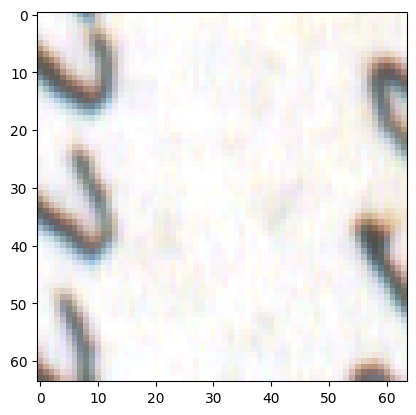

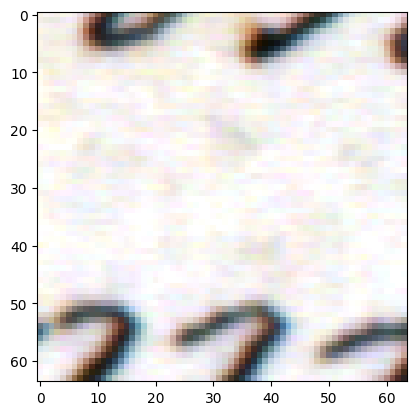

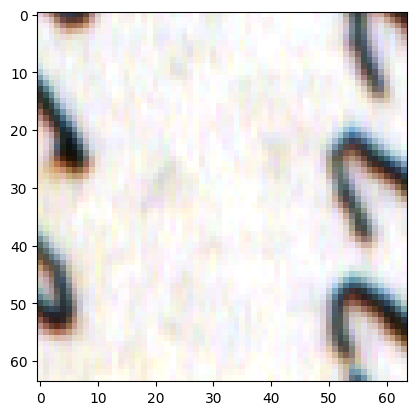

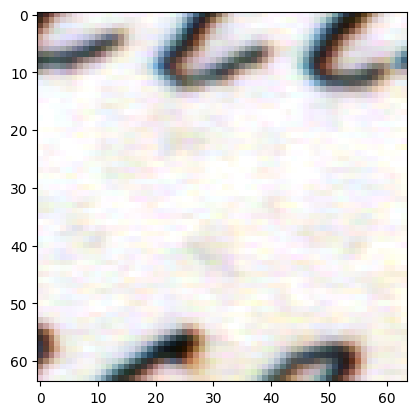

xxxxx


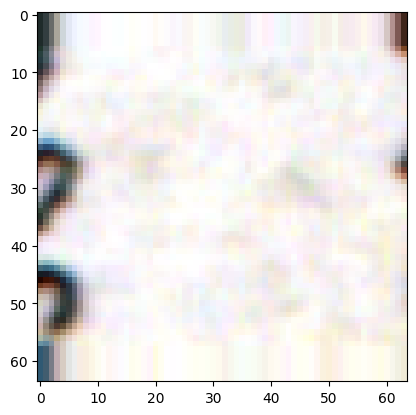

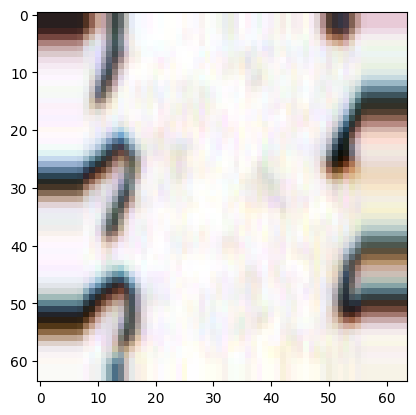

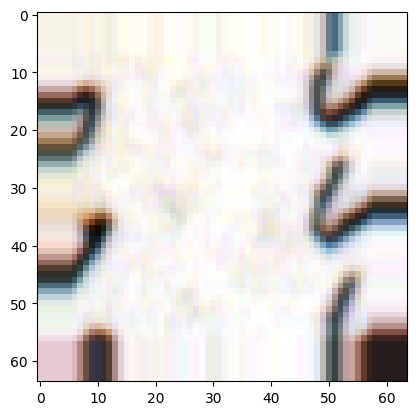

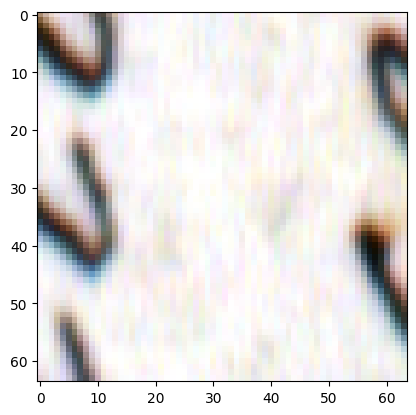

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Load an example image
#img = tf.keras.preprocessing.image.load_img(file_path + "CROP_WB_ViganII_NAP.png")
#x = tf.keras.preprocessing.image.img_to_array(img)
x = train_input[375]
plt.imshow(x)
plt.show()
x = x.reshape((1,) + x.shape)


# Create an instance of the ImageDataGenerator with desired augmentation parameters
datagen = ImageDataGenerator(
    vertical_flip=True,
    horizontal_flip=True,
    zoom_range=0.3,
)

# Generate augmented images with specific rotations
rotations = [90, 180, 270]
num_augmented_images = len(rotations)
i = 0
for angle in rotations:
    augmented_image = datagen.apply_transform(x[0], {'theta': angle})  # Apply specific rotation
    plt.figure(i)
    imgplot = plt.imshow(tf.keras.preprocessing.image.array_to_img(augmented_image))
    i += 1

plt.show()
print("xxxxx")
i = 0
for batch in datagen.flow(x, batch_size=1):
    x = tf.keras.preprocessing.image.array_to_img(batch[0])
    i += 1
    plt.figure(i)
    imgplot = plt.imshow(x)
    if i == 4:
        break

